Here, we'll have a look at the transcript of the [Kamala Harris vs. Donald Trump 2024 debate](https://www.youtube.com/watch?v=lAH6KUOiSB8). 
We'll be using the data prepared by `jumonlala`, and published in the [jumonlala/harris_trump_debate](https://github.com/jumonlala/harris_trump_debate/) github repository. 
The transcript itself was sourced from [ABC News](https://abcnews.go.com/Politics/harris-trump-presidential-debate-transcript/story?id=113560542), 
and subsequently segmented and adorned with some standard NLP features (topic classification as well polarity, subjectivity, and certainty scores). 
If you're interested in the specifics of the data prep, you can find these in [this data prep notebook](https://github.com/jumonlala/harris_trump_debate/blob/main/python/Presidential_Debate_Analysis.ipynb).

Specifically, we'll use the [data/harris_trump.csv](https://github.com/jumonlala/harris_trump_debate/blob/main/data/harris_trump.csv)
data, which contains only the data for harris and trump (presenter's data filtered out).

Let's jump right into it.

# Setup

In [1]:
# few imports we'll use
import os
import io
from functools import partial

import pandas as pd
import numpy as np


## Set a local folder

This is where the data will be downloaded, and artifacts (like embeddings) will be stored.

In [2]:
rootdir = '/Users/thorwhalen/Dropbox/_odata/figiri/harris_vs_trump/'  # set your rootdir here if you want
# ... or set it as an environment variable
rootdir = rootdir or os.getenv('HARRIS_VS_TRUMP_DEBATE', None)

# ensure rootdir exists
if rootdir is None:
    raise ValueError("rootdir is not set")
elif not os.path.exists(rootdir):
    os.mkdir(rootdir)

print(f"{rootdir=}")

rootdir='/Users/thorwhalen/Dropbox/_odata/figiri/harris_vs_trump/'


## Some helper utils

In [3]:
from dol import Files 
from dol import written_bytes, read_from_bytes  # tools to change file-io to byte-io functions 
from graze import graze  # to download data from the web, caching it locally

# `get_data_bytes` will download the data from a url and store it locally 
# under rootdir (using a path based on the url). 
# We use graze here, which means that the next time you call `get_data_bytes` on the same 
# url, the data will be taken from the local file instead so you're nice to the internet
get_data_bytes = partial(graze, rootdir=rootdir)

# make a local "bytes" store to convieniently read and write bytes to and from files under your rootdir
local_store = Files(rootdir)

df_to_parquet_bytes = written_bytes(pd.DataFrame.to_parquet)
parquet_bytes_to_df = read_from_bytes(pd.read_parquet)

## Download the data (once, then get it from cache)

In [4]:
src_url = 'https://raw.githubusercontent.com/jumonlala/harris_trump_debate/refs/heads/main/data/harris_trump.csv'

data = pd.read_csv(io.BytesIO(get_data_bytes(src_url)), index_col=0)
print(f"{data.shape=}")

data.shape=(1141, 8)


Let's have a look at the first row of data:

In [82]:
print(data.iloc[0].to_markdown(headers=[]))

|:-------------|:--------------------------------------------------|
| id           | 14                                                |
| speaker      | KAMALA HARRIS                                     |
| text         | So, I was raised as a middle-class kid            |
| topic        | economy                                           |
| token        | ['so', 'be', 'raise', 'a', 'middle-class', 'kid'] |
| polarity     | 0.0                                               |
| subjectivity | 0.0                                               |
| certainty    | 1.0                                               |


Here are the descriptions of the three semantic features that the data came with, taken directly from 
[the README of our data source](https://github.com/jumonlala/harris_trump_debate/blob/main/README.md).
Like all features, they should be taken with a grain of salt, since all metrics lie, as well as they reveal "truths".


* **Polarity** differentiates between positive and negative sentiments, where +1.0 indicates strongly positive and -1.0 indicates strongly negative.
    For example, 
  
* **Subjectivity** measures objectivity versus subjectivity, with a score of 0.0 being strongly objective and +1.0 highly subjective.
  
* **Certainty** measures the degree of confidence, where +1.0 is highly certain and -1.0 indicates low certainty. 
    For example, the Pattern library notes that “I wish it would stop raining” scores -0.35, while “It will stop raining” scores +0.75. 
    This measure has an accuracy of around 68% on Wikipedia texts.



# Analyze and visualize

## Kick the data around a bit...

What topics were spoken about, and how much (measured by number of "segments")?

In [77]:
print(data.topic.value_counts().to_markdown())

| topic              |   count |
|:-------------------|--------:|
| economy            |     156 |
| abortion           |     137 |
| immigration        |     115 |
| russo ukranian war |     103 |
| capitol attack     |      89 |
| 2020 election      |      82 |
| israel hamas war   |      78 |
| race               |      72 |
| healthcare         |      71 |
| values             |      59 |
| crime              |      54 |
| closing statements |      53 |
| afghanistan        |      40 |
| climate change     |      32 |


How much did each speaker speak?

Obviously, there's several ways we could measure this. Let's have a look at:
* How many segments (that is, data rows) they have (this of course depends on how the data was segmented)
* The length (in number of characters) of the speaker's text
* The length, in number of tokens, so something like "number of words" (except, these are not exactly the words they spoke, but the [lemmatized](https://en.wikipedia.org/wiki/Lemmatization) version of that)


In [52]:
t = pd.DataFrame({
    'number_of_segments': data.speaker.value_counts(),
    'number_of_characters': data.groupby('speaker').text.apply(lambda s: s.str.len().sum()),
    'number_of_words': data.groupby('speaker').text.apply(lambda s: s.str.split().str.len().sum()),
})
print(t.to_markdown())

| speaker       |   number_of_segments |   number_of_characters |   number_of_words |
|:--------------|---------------------:|-----------------------:|------------------:|
| DONALD TRUMP  |                  794 |                  41746 |              8125 |
| KAMALA HARRIS |                  347 |                  32160 |              5913 |


What made me want to look into this data in the first place was this ["Cold Case Solved"](https://medium.com/@alterfero/cold-case-solved-the-silent-38-0-victory-in-the-2024-debate-464053a5ecd9)article, from a linguist analyzing the cognitive impact of each speakers speech. Namely, the fact that though Harris mentions Trump by name 30 times, Trump mentions Harris by name a big round zero times! Let's verify this ourselves with our own data.

In [57]:
harris_text = ' '.join(data[data.speaker == 'KAMALA HARRIS'].text).lower()
trump_text = ' '.join(data[data.speaker == 'DONALD TRUMP'].text).lower()

print(f"Harris mentions 'Donald' {sum(word == 'donald' for word in harris_text.split())} times")
print(f"Harris mentions 'Trump' {sum(word == 'trump' for word in harris_text.split())} times")
print("... and on the other hand,")
print(f"Trump mentions 'Kamala' {sum(word == 'kamala' for word in trump_text.split())} times")
print(f"Trump mentions 'Harris' {sum(word == 'harris' for word in trump_text.split())} times")

Harris mentions 'Donald' 32 times
Harris mentions 'Trump' 30 times
... and on the other hand,
Trump mentions 'Kamala' 0 times
Trump mentions 'Harris' 0 times


## Two word clouds

Let's see what the top words each speaker used were (normalized for normal usage of these words)...

In [83]:
# Note: You'll need the guise library to run this code, 
# but we'll provide a default value if you don't have it, so you can run these cells any way

from contextlib import suppress

# define an empty word_clouds dict to default to if the guise library is not installed
word_clouds = {
    'KAMALA HARRIS': None,
    'DONALD TRUMP': None,
} 

with suppress(ImportError, ModuleNotFoundError):
    # If you don't have the guise library installed, you can install it with: `!pip install guise`
    from guise import word_cloud_store, TFIDFCalculator, english_word_frequencies

    text_store = {
        'KAMALA HARRIS': harris_text,
        'DONALD TRUMP': trump_text,
    }

    en_word_freq = english_word_frequencies()
    words_to_weights = TFIDFCalculator(
        reference_corpus=en_word_freq,
        stopwords={'the', 'and', 'is', 'that', 'they', 'of', 'a', 'to', 'it', 'its', 's', 't', 'we', 'have', 'what'},
        custom_idf=['trump', 'harris']  # words to put on equal footing (give it the same default idf weight, because the word "trump" is a common word as well as one of the speakers name
    )
    word_clouds = word_cloud_store(text_store, words_to_weights=words_to_weights)


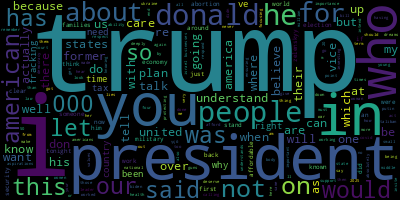

In [ ]:
word_clouds['KAMALA HARRIS']  # if you have the guise library installed, you'll see a word cloud here

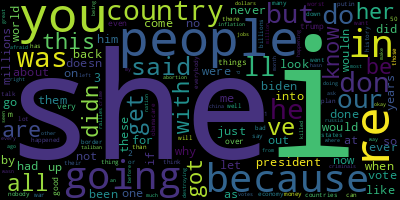

In [ ]:
word_clouds['DONALD TRUMP']  # if you have the guise library installed, you'll see a word cloud here

## A few scatter plots

In [5]:
print(data.iloc[0].to_markdown(headers=[]))

|:-------------|:--------------------------------------------------|
| id           | 14                                                |
| speaker      | KAMALA HARRIS                                     |
| text         | So, I was raised as a middle-class kid            |
| topic        | economy                                           |
| token        | ['so', 'be', 'raise', 'a', 'middle-class', 'kid'] |
| polarity     | 0.0                                               |
| subjectivity | 0.0                                               |
| certainty    | 1.0                                               |


In [7]:
from cosmograph import cosmo  # pip install cosmograph

In [20]:
data['_index'] = range(len(data))
data['speaker_color'] = data.speaker.map({'KAMALA HARRIS': 'blue', 'DONALD TRUMP': 'red'})

cosmo(
   data, 
   
   point_id='_index',
   point_index='_index',

   point_color='speaker_color',
   point_x='polarity',
   point_y='certainty',
   point_size_scale=0.01,
)

Cosmograph(background_color=None, default_link_color=None, default_point_color=None, focused_point_ring_color=…

# Add features: Semantic embeddings/vectors 

We already have some nicely prepared data with a few features, but we want to add some more.
Namely, we're going to vectorize (more precisely, "get semantic vectors" -- known nowadays as "get embeddings") for all text segments and also get some planar projections for these, 
so we can visualize them.

As you see, the text has been tokenized and lemmatized (e.g. "was" -> "be"), and the resulting tokens are available under the `token` column. 
This is convenient for some types of analysis you may want to conduct. 
Here, though, we'll be using modern, transformer-based embeddings (specifically OpenAI's embeddings API) to visualize our text segments, and the embeddings function has it's own tokenizer; Note that this tokenizer doesn't even lemmatize these tokens explicitly -- though it probably does something like lemmatization somewhere under the hood. 



## Get (semantic) embeddings

Now often what we'd want to feed to the embedding is the text segments list (in the order 
it appears in the data), or a {unique_key: text, ...} dictionary, so as to be able to 
align/join our embedding vectors back to the data. 
As the data you're dealing with grows though, you'll find that this way can hit some difficulties. 

If you're referencing you data with a key, you better make sure that your key is unique. 
In our case, it seems like the `id` column would be the candidate for referencing the rows:
Indeed I almost did that myself, and then I checked and found out the `id` as 96 unique values
(so the id is probably some vestigial artifact from data prep). 
A better choice would be the index of the dataframe itself. 

If you use the text segments list itself, in order, you're essentially using the list's (unique)
index as your "alignment information", but you could be wasting time and money if many segments are duplicated
(which can happen a lot in speech). Sure, embeddings are cheap, but in some cases it can add up!



In [5]:
print(f"Number of unique ids: {data['id'].nunique()}")
print(f"Number of text segments: {len(data)}")
print(f"Number of unique text segments: {data['text'].nunique()}")

Number of unique ids: 96
Number of text segments: 1141
Number of unique text segments: 1132


Oh, go on! Let's see what these duplicated text segments are!

In [6]:
duplicated_text = data[data.duplicated('text', keep=False)]
print(f"Number of duplicated text segments: {len(duplicated_text)}")
print(f"Number of unique duplicated text segments: {duplicated_text['text'].nunique()}")
duplicated_text[['speaker', 'text']].sort_values('text').head(10)

Number of duplicated text segments: 18
Number of unique duplicated text segments: 9


,speaker,text
861,DONALD TRUMP,He's got nuclear weapons
859,DONALD TRUMP,He's got nuclear weapons
938,DONALD TRUMP,I don't know
81,DONALD TRUMP,I don't know
616,KAMALA HARRIS,Let's not go back
628,KAMALA HARRIS,Let's not go back
757,DONALD TRUMP,She hates Israel
753,DONALD TRUMP,She hates Israel
974,DONALD TRUMP,She is Biden
971,DONALD TRUMP,She is Biden


In [ ]:
save_filename = 'openai_embeddings.parquet'

if save_filename in local_store:
    # get the saved embeddings from the local store
    bytes_ = local_store[save_filename]
    text_and_embeddings_df = read_from_bytes(pd.read_parquet, bytes_)
else:
    print("Computing (then saving) OpenAI embeddings for the text segments...")
    # compute and save embeddings (this took 6.5s on my computer)
    import oa  # pip install oa  (you'll also need to set OPENAI_API_KEY as an environment variable)

    # note: the sorted is important to ensure you'll be able to have a consistent order 
    # and be able to align the embeddings with the text
    sorted_unique_text_segments = sorted(set(data['text'])) 

    embeddings = oa.embeddings(sorted_unique_text_segments)
    text_and_embeddings_df = pd.DataFrame({'text': sorted_unique_text_segments, 'embeddings': embeddings})
    local_store[save_filename] = df_to_parquet_bytes(text_and_embeddings_df)


In [9]:
print(f"{text_and_embeddings_df.shape=}\n")
print(f"First row: {text_and_embeddings_df.iloc[0]}\n")
print(f"Size of vectors: {len(text_and_embeddings_df['embeddings'].iloc[0])}")

text_and_embeddings_df.shape=(1132, 2)

First row: text          $6,000 for young families for the first year o...
embeddings    [0.018508581444621086, 0.006474844645708799, 0...
Name: 0, dtype: object

Size of vectors: 1536


## Getting planar embeddings

Now you want to visualize these multi-dimensional points on a screen. 
This is going to require (implicitly or explicitly) to get some planar (that is, `(x, y)`) coordinates for each of your points. 
There's many ways to do this. How do you chose. 

Well, first: **Why are you doing this?**.

You’re not just passively observing your data; you’re courting it, trying to tease out the stories it’s holding back. Choosing how to slice it—how to look at it—becomes an act of intent, of will, even of ideology. The projection you pick shapes the truth you end up seeing. Sometimes you’re playing favorites, picking the lens that aligns with your narrative. Other times, you’re a relentless skeptic, rotating through different projections, mining for the subtle cracks where deeper truths might leak through. Each choice, each transformation, tells a different story, frames a different reality—and understanding this is half the game.

Here, we'll try a few representative methods, sticking to those that are included in scikit-learn, which pretty much everyone has lying around. 
But know that there are many more choices to check out. Namely, 
[Uniform Manifold Approximation and Projection (UMAP)](https://umap-learn.readthedocs.io/en/latest/) (see [umap-learn](https://umap-learn.readthedocs.io/en/latest/) package),
[Autoencoders](https://machinelearningmastery.com/dimensionality-reduction-algorithms-with-python/) (see [TensorFlow](https://www.tensorflow.org/guide/keras/autoencoders) or [PyTorch](https://pytorch.org/tutorials/recipes/recipes/autoencoder_recipe.html) packages),
[Projection Pursuit](https://en.wikipedia.org/wiki/Projection_pursuit) (see [direpack](https://pypi.org/project/direpack/) package), 
[Independent Component Analysis (ICA)](https://cmdlinetips.com/2022/08/7-dimensionality-reduction-techniques-by-examples-in-python/) (see [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html) package),
[Maximum Variance Unfolding (MVU)](https://en.wikipedia.org/wiki/Semidefinite_embedding) (see [MVU](https://github.com/lvdmaaten/mvu) package), etc. 

| **Method Name**          | **What it Reveals**                                  | **Advantages**                                                                 | **Disadvantages**                                                           | **scikit-learn Code**                                                                                          |
|---------------------------|-----------------------------------------------------|-------------------------------------------------------------------------------|-----------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------|
| **PCA**                  | Dominant variance patterns in data.                 | Simple, interpretable, and computationally efficient.                        | Only linear relationships; ignores local or nonlinear structures.           | `from sklearn.decomposition import PCA`<br>`pca = PCA(n_components=2)`<br>`planar_embeddings = pca.fit_transform(X)`       |
| **Random Projection**     | Preserves pairwise distances approximately.         | Extremely fast and lightweight; good for large datasets.                     | Lack of interpretability; may lose significant structure.                   | `from sklearn.random_projection import GaussianRandomProjection`<br>`rp = GaussianRandomProjection(n_components=2)`<br>`planar_embeddings = rp.fit_transform(X)` |
| **t-SNE**                | Local clustering and similarity relationships.       | Captures nonlinear local structure; visually intuitive.                      | Computationally expensive; sensitive to hyperparameters.                    | `from sklearn.manifold import TSNE`<br>`tsne = TSNE(n_components=2, random_state=42)`<br>`planar_embeddings = tsne.fit_transform(X)` |
| **Kernel PCA**            | Nonlinear patterns using a kernel function.         | Captures nonlinear relationships; flexible with choice of kernels.           | Computationally intensive; kernel selection can be tricky.                  | `from sklearn.decomposition import KernelPCA`<br>`kpca = KernelPCA(n_components=2, kernel='rbf')`<br>`planar_embeddings = kpca.fit_transform(X)` |
| **Linear Discriminant Analysis (LDA)** | Maximizes separability between categories.           | Directly focuses on class separability; interpretable.                       | Assumes linear boundaries; sensitive to imbalanced classes.                 | `from sklearn.discriminant_analysis import LinearDiscriminantAnalysis`<br>`lda = LinearDiscriminantAnalysis(n_components=2)`<br>`planar_embeddings = lda.fit_transform(X, y)` |

In [10]:
# concatinate the lists of embeddings into a 2D array
X = np.stack(text_and_embeddings_df['embeddings'])


In [11]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

planar_embedding_unsupervised_learners = {
    'pca': PCA(n_components=2),
    'random_projection': GaussianRandomProjection(n_components=2, random_state=42),
    'tsne': TSNE(n_components=2, random_state=42),
    'kernel_pca': KernelPCA(n_components=2, kernel='rbf'),
}

# fit the learners
for name, learner in planar_embedding_unsupervised_learners.items():

    print(f"Fitting {name}...")
    X_2d = learner.fit_transform(X)
    text_and_embeddings_df[f'{name}__x'] = X_2d[:, 0]
    text_and_embeddings_df[f'{name}__y'] = X_2d[:, 1]


Fitting pca...
Fitting random_projection...
Fitting tsne...
Fitting kernel_pca...


In [41]:
try:
    df = parquet_bytes_to_df(local_store['harris_vs_trump_debate_with_extras.parquet'])
except KeyError:
    import pandas as pd
    import io

    text_and_embeddings_df = parquet_bytes_to_df(local_store['harris_vs_trump_debate.parquet'])


    # join data to text_and_embeddings_df
    df = data.merge(text_and_embeddings_df, on='text', how='left')

    df['_index'] = range(len(df))  # TODO: get rid of need of this

    # make a column that has a unique id for each speaker
    df['speaker_id'] = df['speaker'].map({speaker: i for i, speaker in enumerate(df['speaker'].unique())})
    colors = ['blue', 'red']
    df['speaker_color'] = df['speaker'].map({speaker: colors[i] for i, speaker in enumerate(df['speaker'].unique())})
    # same for topic
    df['topic_id'] = df['topic'].map({topic: i for i, topic in enumerate(df['topic'].unique())})

    local_store['harris_vs_trump_debate_with_extras.parquet'] = df_to_parquet_bytes(df)


# peek at the first row
df.iloc[0]

id                                                                     14
speaker                                                     KAMALA HARRIS
text                               So, I was raised as a middle-class kid
topic                                                             economy
token                   ['so', 'be', 'raise', 'a', 'middle-class', 'kid']
polarity                                                              0.0
subjectivity                                                          0.0
certainty                                                             1.0
embeddings              [0.015647249296307564, -0.006923337001353502, ...
pca__x                                                          -0.143514
pca__y                                                           0.135135
random_projection__x                                            -1.130084
random_projection__y                                              1.32939
tsne__x                               

# Visualizations

In [106]:
from cosmograph import cosmo
import inspect 

print(*inspect.signature(cosmo).parameters, sep=', ')
# help(base_cosmo)

disable_simulation, simulation_decay, simulation_gravity, simulation_center, simulation_repulsion, simulation_repulsion_theta, simulation_repulsion_quadtree_levels, simulation_link_spring, simulation_link_distance, simulation_link_dist_random_variation_range, simulation_repulsion_from_mouse, simulation_friction, background_color, space_size, default_point_color, point_greyout_opacity, default_point_size, point_size_scale, hovered_point_cursor, render_hovered_point_ring, hovered_point_ring_color, focused_point_ring_color, focused_point_index, render_links, default_link_color, link_greyout_opacity, default_link_width, link_width_scale, curved_links, curved_link_segments, curved_link_weight, curved_link_control_point_distance, default_link_arrows, link_arrows_size_scale, link_visibility_distance_range, link_visibility_min_transparency, use_quadtree, show_FPS_monitor, pixel_ratio, scale_points_on_zoom, initial_zoom_level, disable_zoom, enable_drag, fit_view_on_init, fit_view_delay, fit_vie

In [107]:
help(cosmo)    

Help on function cosmo in module cosmograph.base:

cosmo(*, disable_simulation: bool = False, simulation_decay: float = 1000, simulation_gravity: float = 0, simulation_center: float = 0, simulation_repulsion: float = 0.1, simulation_repulsion_theta: float = 1.7, simulation_repulsion_quadtree_levels: float = 12, simulation_link_spring: float = 1, simulation_link_distance: float = 2, simulation_link_dist_random_variation_range: list[typing.Any] = [1, 1.2], simulation_repulsion_from_mouse: float = 2, simulation_friction: float = 0.85, background_color: Union[str, list[float]] = '#222222', space_size: int = 4096, default_point_color: Union[str, list[float]] = None, point_greyout_opacity: float = 0.1, default_point_size: float = None, point_size_scale: float = 1, hovered_point_cursor: str = None, render_hovered_point_ring: bool = 0.7, hovered_point_ring_color: Union[str, list[float]] = 'white', focused_point_ring_color: Union[str, list[float]] = 0.95, focused_point_index: int = None, render

In [108]:
from i2 import docstring_to_params
from i2.doc_mint import find_in_params

results = find_in_params('label', base_cosmo)
print(f"{len(results)=}")
results[:2]

len(results)=11


[{'name': 'point_label',
  'default': None,
  'annotation': str,
  'description': 'Column name for associated point labels.'},
 {'name': 'point_label_weight',
  'default': None,
  'annotation': str,
  'description': 'Column name for point label weights.'}]

In [ ]:
cosmo(
    
   points=df, 
   
   point_id='_index',
   point_index='_index',

   point_color='speaker_color',
   point_label='text',
   point_size='polarity',
   point_x='tsne__x',
   point_y='tsne__y',
   point_size_scale=4.2,
)

Cosmograph(background_color=None, default_link_color=None, default_point_color=None, focused_point_ring_color=…

In [19]:
base_cosmo(
   points=df, 
   
   point_id='_index',
   point_index='_index',

   point_color='speaker_color',
   point_x='polarity',
   point_y='certainty',
   point_size_scale=0.01,
)

Cosmograph(background_color=None, default_link_color=None, default_point_color=None, focused_point_ring_color=…

In [ ]:
from cosmograph._resources import _get_fresh_color_table, ResourcesDacc

resouces = ResourcesDacc()


In [19]:
t = pd.read_html('https://www.w3.org/TR/css-color-4/#named-colors')
len(t)

47

In [51]:
_color_table_columns = ['Color\xa0name', 'Hex\xa0rgb', 'Decimal']
color_table = next(filter(lambda df: set(_color_table_columns).issubset(df.columns), t), None)
color_table = color_table[_color_table_columns]
color_table.columns = color_table.columns.map(lambda x: x.replace('\xa0', '_').lower())
assert color_table['color_name'].nunique() == len(color_table), "color names are not unique"
color_table


,color_name,hex_rgb,decimal
0,aliceblue,#f0f8ff,240 248 255
1,antiquewhite,#faebd7,250 235 215
2,aqua,#00ffff,0 255 255
3,aquamarine,#7fffd4,127 255 212
4,azure,#f0ffff,240 255 255
...,...,...,...
143,wheat,#f5deb3,245 222 179
144,white,#ffffff,255 255 255
145,whitesmoke,#f5f5f5,245 245 245
146,yellow,#ffff00,255 255 0


In [15]:
import cosmograph_widget

cosmograph_widget.__file__

'/Users/thorwhalen/Dropbox/py/proj/c/cosmograph_widget/src/cosmograph_widget/__init__.py'

In [4]:
# from cosmograph_widget import Cosmograph

## Supervised projections

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2).fit(X, data['speaker'])

In [64]:
print(f"{data.shape=}\n")
print(f"First row:\n{data.iloc[0]}")

data.shape=(1141, 8)

First row:
id                                                             14
speaker                                             KAMALA HARRIS
text                       So, I was raised as a middle-class kid
topic                                                     economy
token           ['so', 'be', 'raise', 'a', 'middle-class', 'kid']
polarity                                                      0.0
subjectivity                                                  0.0
certainty                                                     1.0
Name: 0, dtype: object
